**Name:** Trini Kui

**StudentID:** 21204004

In [99]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt

# Task 2

Replicate the classifier training and evaluation from the Lab 4 notebook but with the seeds.csv dataset. Formulate a binary classification problem and transform the **type** column accordingly. Summarize your conclusions (max 200 words)

*Exemplary*
- Binary classification problem formulated and justified. A clear discussion of the cost of misclassifying examples
- Best classifier identified. Parameter exploration implemented successfully, presented well and summarized correctly.

In [59]:
df = pd.read_csv("./seeds.csv")

## EDA - Exploratory Data Analysis

In [11]:
df.head(10)

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   
5  14.38      14.21       0.8951             5.386            3.312   
6  14.69      14.49       0.8799             5.563            3.259   
7  14.11      14.10       0.8911             5.420            3.302   
8  16.63      15.46       0.8747             6.053            3.465   
9  16.44      15.25       0.8880             5.884            3.505   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1  
5                  2.462                    4.956     1  
6                  3.586                    5.219     1  
7                  2.700                    5.000     1  
8                  2.040                    5.877     1  
9                  1.969                    5.533     1

All features are numerical so I don't need to do any categorical encoding.

In [60]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

The classification types are eventually spread out (1/3 each) in the dataset. 

In [61]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values, good, so don't need to do anything here. 

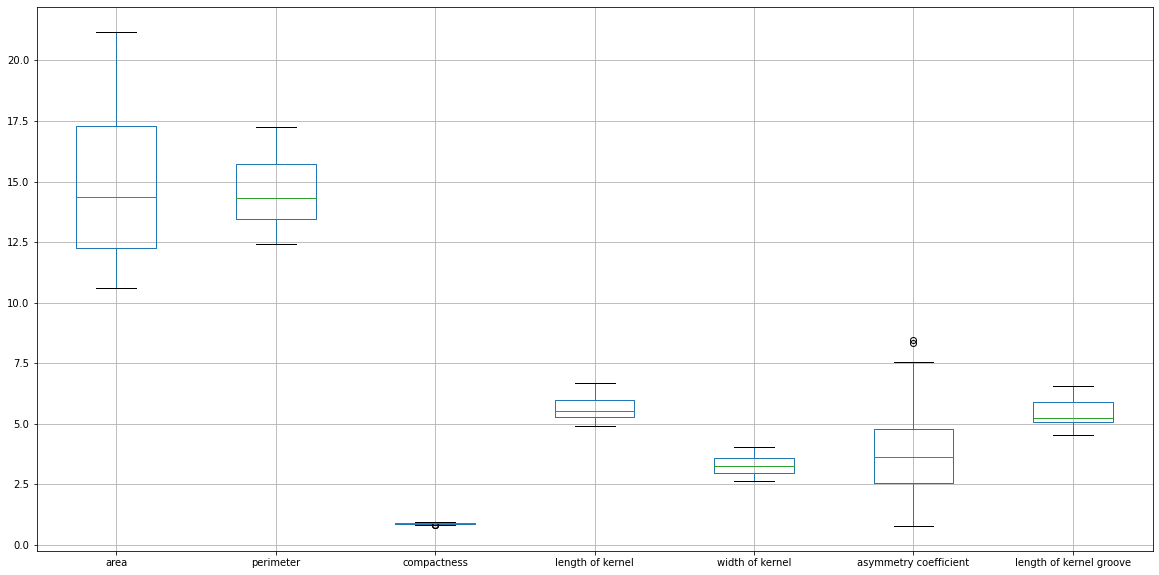

In [62]:
df.loc[:,df.columns != 'type'].boxplot(figsize=(20,10)) #shows all columns except the target 'type' column
plt.show()

Seems like only really the `asymmetry coefficient` and maybe `compactness` columns have some outliers. I want to get a better visual idea of the distribution by using histograms below.

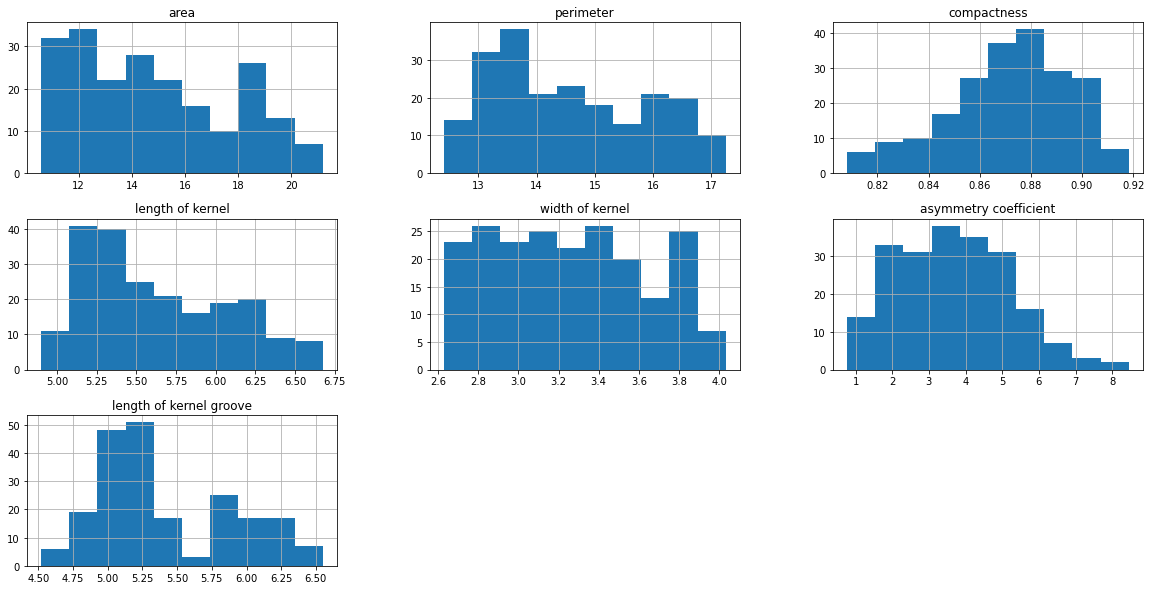

In [63]:
df.loc[:,df.columns != 'type'].hist(figsize=(20,10))
plt.show()

The outliers in `asymmetry coefficient` and `compactness` don't look too bad. Maybe a bit of a tail, which we can improve on with a log transform and robust scaler to better deal with the outliers. For the other features, I will use a standard scaler. See the next section...

## Data Preparation

The etivity asks for binary classification so I will change `types 1 & 2 to class 1` and change `type 3 to class 0` per the etivity 4 Q&A forum replies from the professor.

In [64]:
df['type'] = df['type'].replace(to_replace = 2, value = 1)
df['type'] = df['type'].replace(to_replace = 3, value = 0)
df['type'].value_counts()

1    140
0     70
Name: type, dtype: int64

Before we scale or transform the data, we need to separate out the dataset into the train and test data to avoid contaminating the test dataset. 

### Separate train and test datasets

In [65]:
y = df['type']
X = df.drop('type', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### Pipeline & GridCV

Using pipeline to do the data preparation.

In [66]:
 #alternative for [c for c in df if c not in ['type']]
col_all = list(df.columns)
col_all = col_all[:-1] #all columns except the predictor column 'type'

col_outlier = ['compactness','asymmetry coefficient'] #features with outliers
col_no_outlier = list(set(col_all) - set(col_outlier)) #all other features

In [67]:
#### From Lab 4 ####

# Add column names after splitting dataset into train and test
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

# Select particular group of columns


class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]


# Pipeline to add back column names and data prep different group of columns differently
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=col_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=col_outlier),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=col_no_outlier),
            StandardScaler()
        ))
    ])
)


I will use the default parameter search used in Lab 4. If I add too much, it might take too long to run. 

#### SVM Algorithm

In [68]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)  # training happens here! SVM is trained 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.964:
Best parameters:  {'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


#### Random Forest Classifier

In [69]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.953:
Best parameters:  {'rf__max_depth': 6, 'rf__n_estimators': 20}


### SVM vs Random Forest Classifier

In [72]:
#### from Lab 4 ####

mean_fpr = np.linspace(start=0, stop=1, num=100)

# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [73]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

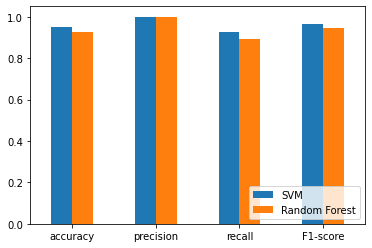

In [74]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

*precision* looks the same for both SVM and Random Forest, but SVM is better for all other metrics. **I will use SVM**.

Let's look at the ROC curve first. It shows the performance of a classification model at all classification thresholds by plotting 2 parameters:
- True positive rate
- False positive rate

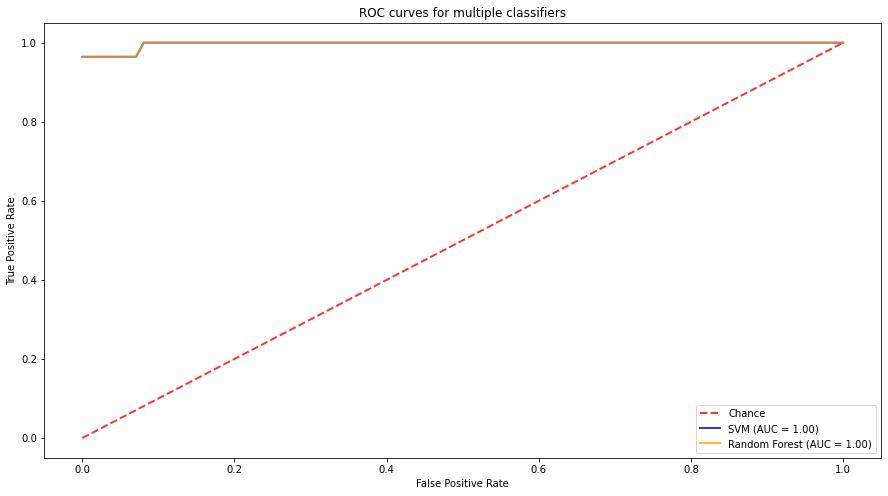

In [77]:
plt.figure(figsize=(15,8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

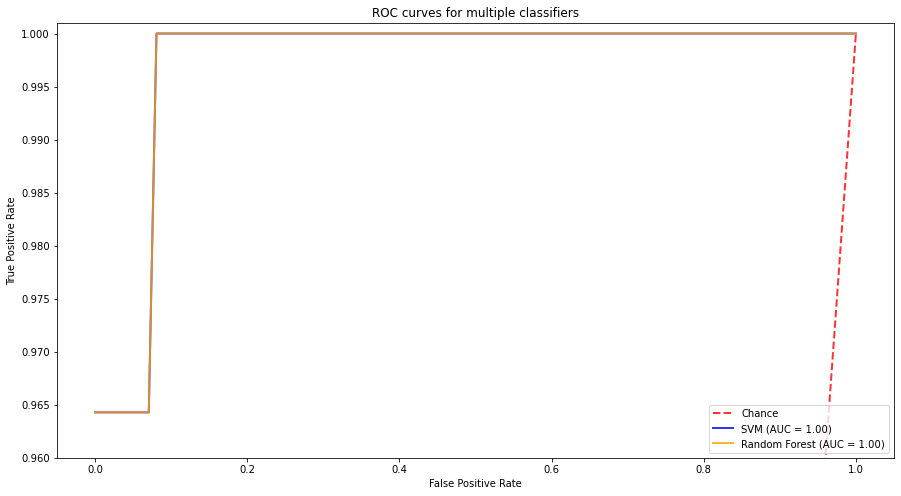

In [81]:
plt.figure(figsize=(15,8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.ylim(ymax=1.001,ymin=0.96) #tried zooming in
plt.legend(loc="lower right")
plt.show()

Of course both classifiers performed better than a random guess. Visually, it's really hard to tell whether SVM or Random Forest is better even when zoomed in. I will still go with SVM, but if someone else went with Random Forest, I don't think they'd do much worse. 

### Train Final Model

https://datascience.stackexchange.com/questions/33008/is-it-always-better-to-use-the-whole-dataset-to-train-the-final-model
- Okay to train final model on full dataset when put into production but you can't rely on performance scores anymore

In [83]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

# Task 3

Train a third classifier (ex. MLPClassifier, Naive Bayes, kNN) with seeds.csv and compare it to both SVM and Random Forest. Summarize your experience with exploring the parameters (max 150 words)

*Exemplary*
- 3rd classifier trained correctly and compared correctly to SVM and Random Forest

## KNeighborsClassifier

In [104]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                ('KN', neighbors.KNeighborsClassifier())])

param_grid = {
    'KN__n_neighbors': [2, 5, 7, 9],
    'KN__weights': ['uniform','distance'],
    'KN__leaf_size': [10,20,30,40,50,60],
    'KN__algorithm': ['auto','ball_tree','kd_tree','brute']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)  # training happens here! SVM is trained 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KN_best_params = search.best_params_
KN_best_model = search.best_estimator_

Best CV score = 0.964:
Best parameters:  {'KN__algorithm': 'auto', 'KN__leaf_size': 10, 'KN__n_neighbors': 2, 'KN__weights': 'distance'}


In [105]:
KN_accuracy, KN_precision, KN_recall, KN_f1_score, KN_tpr, KN_auc = evaluate_model(X_test, y_test, KN_best_model)

## SVM vs RF vs KN

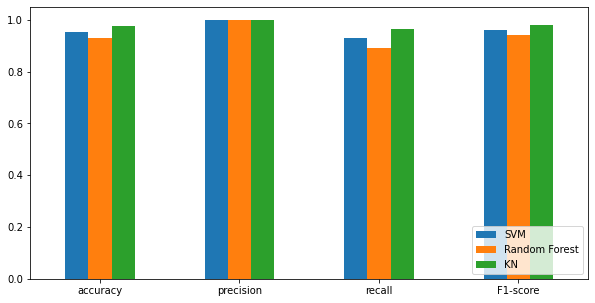

In [110]:
KN_metrics = np.array([KN_accuracy, KN_precision, KN_recall, KN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'KN': KN_metrics}, index=index)
df_metrics.plot.bar(rot=0, figsize=(10,5))
plt.legend(loc="lower right")
plt.show()

In [107]:
name_list = ['accuracy','precision','recall','f1 score']
for i in range(len(name_list)):
    print('{}: SVM {:f} | Random Forest {:f} | KN {:f}'.format(name_list[i],SVM_metrics[i],RF_metrics[i],KN_metrics[i]))

accuracy: SVM 0.952381 | Random Forest 0.928571 | KN 0.976190
precision: SVM 1.000000 | Random Forest 1.000000 | KN 1.000000
recall: SVM 0.928571 | Random Forest 0.892857 | KN 0.964286
f1 score: SVM 0.962963 | Random Forest 0.943396 | KN 0.981818


Once again, precision seems to be the same (1 for all 3 classifiers). However for all other metrics in the bar graph, KNeighbours performs the best.  

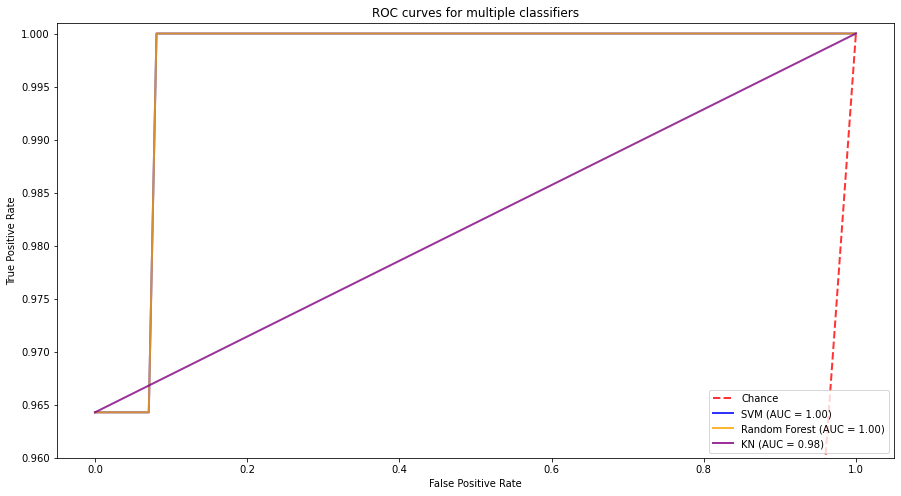

In [112]:
plt.figure(figsize=(15,8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KN_tpr[0,:], lw=2, color='purple', label='KN (AUC = %0.2f)' % (KN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.ylim(ymax=1.001,ymin=0.96) #tried zooming in
plt.legend(loc="lower right")
plt.show()